<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек


1. Обучите автокодировщик на 10 выбранных вами красивых цифрах 5 и отредактируйте с помощью него все остальные цифры 5
2. Напишите 3 автокодировщика для подавления шума с собственными архитектурами. Сравните их между собой и с исходным шумоподавляющим атокодировщиком. Сравнивайте по квадрату разности исходной картинки с востановленной из шума
3. Обучите автокодировщик на базе Fashion Mnist, проверьте, как он преобразует картинки одежды, на которых не обучался

In [ ]:
from tensorflow.python.keras.layers.core import Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, SpatialDropout1D, Flatten, Conv2D, Conv2DTranspose, concatenate, Input, Activation, MaxPooling2D, Reshape
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras import backend as K # новенькое. базовые функции Кераса
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображений

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import os
import time, random
from google.colab import drive
import seaborn as sns
sns.set_style('darkgrid')

# База MNIST и 10 цифр "5"

numbers = [35,47,173,175,191,287,335,396,403,417]

In [ ]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data() 
xTrainMnist = xTrainMnist.astype('float32')/255 
xTrainMnist = xTrainMnist.reshape(-1, 28, 28, 1) 
xTestMnist = xTestMnist.astype('float32')/255 
xTestMnist = xTestMnist.reshape(-1, 28, 28, 1) 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
numbers = [35,47,173,175,191,287,335,396,403,417]
allFive = xTrainMnist[yTrainMnist==5]
allFive = allFive.astype('float32')/255
allFive = allFive.reshape(-1, 28, 28, 1)

In [ ]:
allFive.shape

(5421, 28, 28, 1)

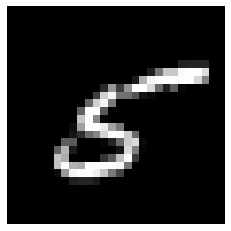

In [ ]:
test_img = xTrainMnist[191] # Берем  изображение  цифры 5 из тестовой выборки
plt.imshow(test_img.reshape(28,28), cmap='gray') #  изображение
plt.axis('off') # Отклюачем подписи осей
plt.show()

In [ ]:
xTrain_10 = xTrainMnist[numbers]
xTrain_10.shape

(10, 28, 28, 1)

# Функции

In [ ]:
def baseAutoencoder(shape=(28,28,1)): 
    img_input = Input((shape)) # зачем вторые скобки ? 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x)  
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) 
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    return model 

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)):
  n = 10
  plt.figure(figsize=(20, 9))
  for i in range(n):
    index = np.random.randint(0, pred.shape[0]) 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(pred[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
def getMSE(x1, x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1 - x2
  return sum(delta**2)/len(delta)

# Базовая нейронная сеть

In [ ]:
model_10 = baseAutoencoder((28, 28, 1))

In [ ]:
model_10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0     

In [ ]:
history_base = model_10.fit(xTrain_10, xTrain_10, batch_size=256, epochs=500, validation_data=(xTrain_10, xTrain_10))

Epoch 1/500
1/1 [==============================] - 10s 10s/step - loss: 0.2889 - accuracy: 0.4573 - val_loss: 0.2293 - val_accuracy: 0.8482
Epoch 2/500
1/1 [==============================] - 0s 40ms/step - loss: 0.2277 - accuracy: 0.5774 - val_loss: 0.2256 - val_accuracy: 0.8482
Epoch 3/500
1/1 [==============================] - 0s 39ms/step - loss: 0.1911 - accuracy: 0.6565 - val_loss: 0.2218 - val_accuracy: 0.8482
Epoch 4/500
1/1 [==============================] - 0s 38ms/step - loss: 0.1645 - accuracy: 0.7125 - val_loss: 0.2180 - val_accuracy: 0.8482
Epoch 5/500
1/1 [==============================] - 0s 37ms/step - loss: 0.1432 - accuracy: 0.7547 - val_loss: 0.2142 - val_accuracy: 0.8482
Epoch 6/500
1/1 [==============================] - 0s 36ms/step - loss: 0.1262 - accuracy: 0.7802 - val_loss: 0.2103 - val_accuracy: 0.8482
Epoch 7/500
1/1 [==============================] - 0s 35ms/step - loss: 0.1119 - accuracy: 0.7992 - val_loss: 0.2062 - val_accuracy: 0.8482
Epoch 8/500
1/1 [===

In [ ]:
predTrainMnist = model_10.predict(xTrain_10)
predTrainMnist = predTrainMnist*255
predTrainMnist = predTrainMnist.astype('uint8')

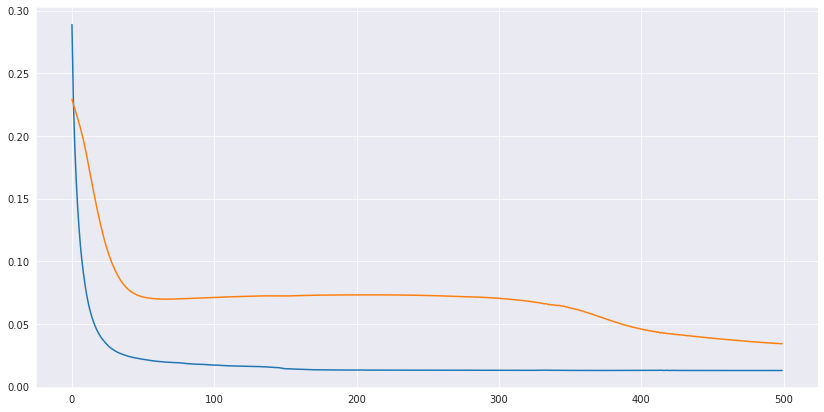

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.show()

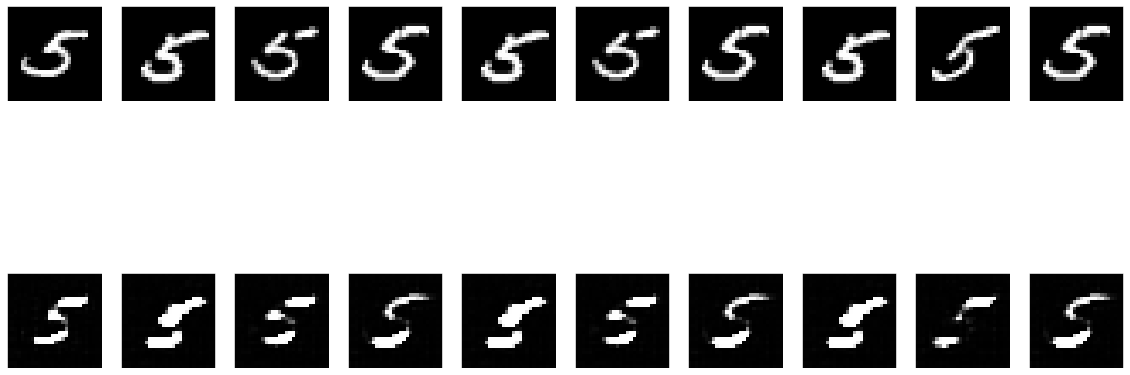

In [ ]:
plotImages(xTrain_10, predTrainMnist, shape=(28, 28))

In [ ]:
err_base = [getMSE(xTrain_10[i], predTrainMnist[i]/255 ) for i in range(len(predTrainMnist))]
print('ERROR:', sum(err_base)/xTrainMnist.shape[0])

ERROR: 5.726710683625879e-06


# 1-ая своя архитектура. С Dropout.

In [ ]:
from tensorflow.python.ops.numpy_ops.np_array_ops import pad
def myAutocoderOne (shape=(28, 28, 1),):
  img_input = Input((shape))
  x = Conv2D(128, (2, 2), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(128, (2, 2), padding='same', activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  z = MaxPooling2D()(x)

  x = Conv2DTranspose(32, (2, 2), padding='same', strides=(2, 2), activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
  x = Dropout(0.2)(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(16, (2, 2), padding='same', strides=(2, 2), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(16, (2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
  return model

In [ ]:
myModelOne = myAutocoderOne((28, 28, 1))

In [ ]:
myModelOne.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 128)       640       
                                                                 
 batch_normalization_10 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 128)       65664     
                                                                 
 dropout (Dropout)           (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 128)      512       
 chNormalization)                                          

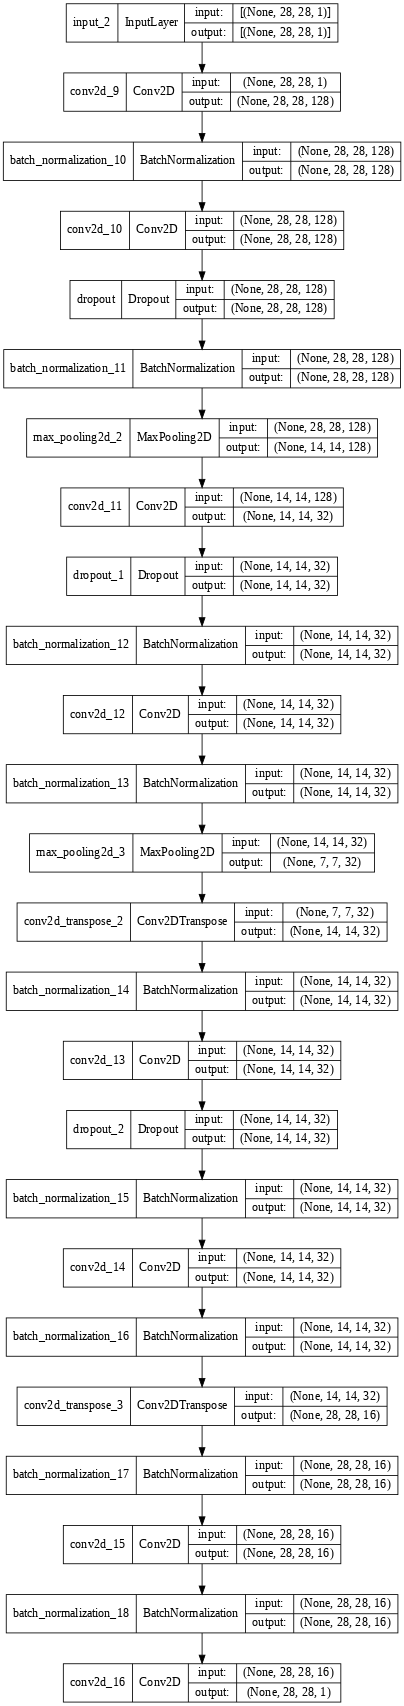

In [ ]:
utils.plot_model(myModelOne, dpi=60, show_shapes=True)

In [ ]:
history = myModelOne.fit(xTrain_10, xTrain_10, batch_size=256, epochs=500, validation_data=(allFive, allFive))

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.2971 - accuracy: 0.3816 - val_loss: 0.2471 - val_accuracy: 0.8057
Epoch 2/500
1/1 [==============================] - 0s 290ms/step - loss: 0.2799 - accuracy: 0.4156 - val_loss: 0.2448 - val_accuracy: 0.8057
Epoch 3/500
1/1 [==============================] - 0s 294ms/step - loss: 0.2710 - accuracy: 0.4473 - val_loss: 0.2423 - val_accuracy: 0.8057
Epoch 4/500
1/1 [==============================] - 0s 292ms/step - loss: 0.2613 - accuracy: 0.4745 - val_loss: 0.2399 - val_accuracy: 0.8057
Epoch 5/500
1/1 [==============================] - 0s 299ms/step - loss: 0.2535 - accuracy: 0.4964 - val_loss: 0.2374 - val_accuracy: 0.8057
Epoch 6/500
1/1 [==============================] - 0s 297ms/step - loss: 0.2484 - accuracy: 0.5144 - val_loss: 0.2350 - val_accuracy: 0.8057
Epoch 7/500
1/1 [==============================] - 0s 293ms/step - loss: 0.2410 - accuracy: 0.5291 - val_loss: 0.2327 - val_accuracy: 0.8057
Epoch 8/500
1/1 

In [ ]:
predTest = myModelOne.predict(xTrain_10)
predTest = predTest*255
predTest = predTest.astype('uint8')

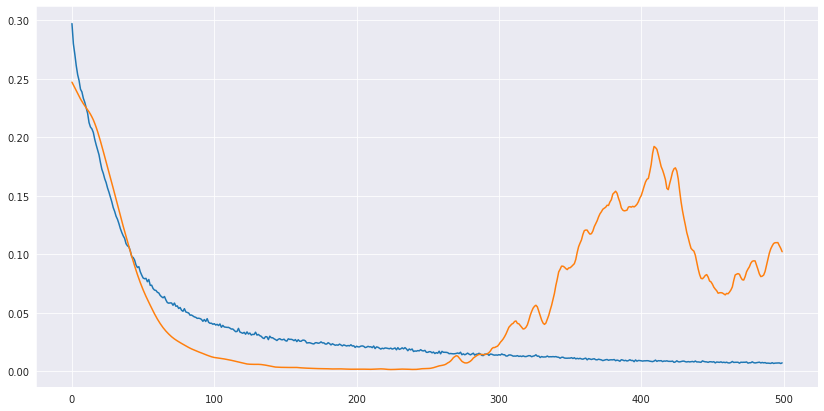

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

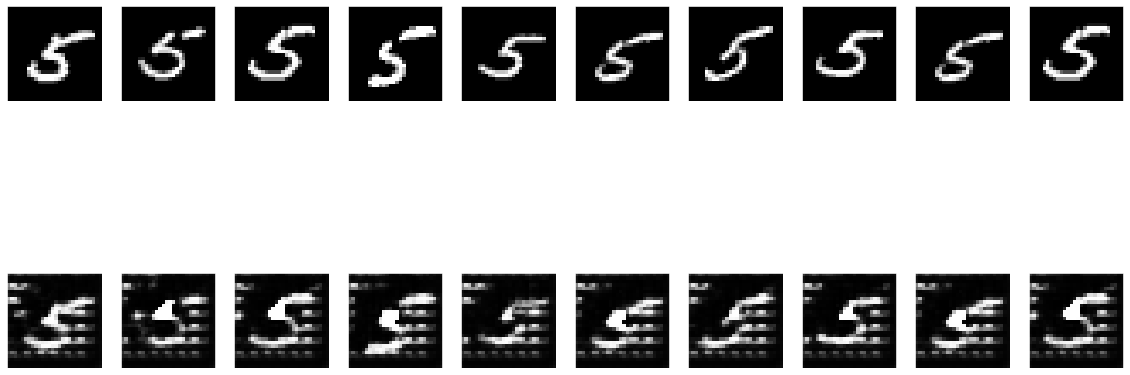

In [ ]:
plotImages(xTrain_10, predTest, shape=(28, 28))

In [ ]:
err_two = [getMSE(xTrain_10[i], predTest[i]/255) for i in range(len(predTest))]

In [ ]:
print('ERROR:', sum(err_two)/predTest.shape[0])

ERROR: 0.045495604217670044


тут для интереса ипользовал вадидацию всех пятёрок из базы. Не знаю, что правильней. В теории при увеличении эпох результат будет лучше.

# 2-ая своя архитектура



---



In [ ]:
def myAutocoderTwo(shape=(28, 28, 1)):
  img_input = Input((shape))
  x = Conv2D(32, (3, 3), strides=2, padding='same',  activation='relu')(img_input)
  x = Conv2D(32, (3, 3), strides=2, padding='same',  activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (2, 2), padding='same', activation='relu')(x)
 
  z = Dense(16, activation='relu')(x)

  x = Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', activation='relu')(z)
  x = Conv2D(64, (2, 2), padding='same', activation='relu')(z)
  x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
  x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
  
  

  model =Model(img_input, x)
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model


In [ ]:
modelTwo = myAutocoderTwo()

In [ ]:
modelTwo.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 batch_normalization_19 (Bat  (None, 7, 7, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 64)          8256      
                                                                 
 dense (Dense)               (None, 7, 7, 16)          1040      
                                                           

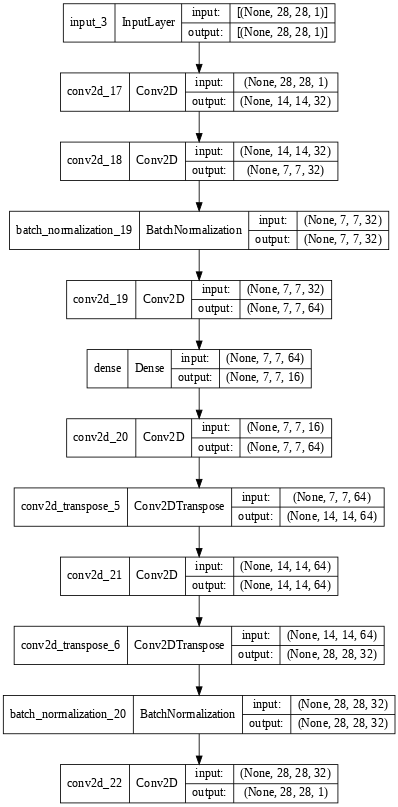

In [ ]:
utils.plot_model(modelTwo, dpi=60, show_shapes=True)

In [ ]:
history_02 = modelTwo.fit(xTrain_10, xTrain_10, batch_size=256, epochs=500, validation_data=(allFive, allFive))

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.2452 - val_loss: 0.2477
Epoch 2/500
1/1 [==============================] - 0s 144ms/step - loss: 0.2313 - val_loss: 0.2456
Epoch 3/500
1/1 [==============================] - 0s 142ms/step - loss: 0.2255 - val_loss: 0.2436
Epoch 4/500
1/1 [==============================] - 0s 144ms/step - loss: 0.2198 - val_loss: 0.2414
Epoch 5/500
1/1 [==============================] - 0s 140ms/step - loss: 0.2132 - val_loss: 0.2392
Epoch 6/500
1/1 [==============================] - 0s 143ms/step - loss: 0.2058 - val_loss: 0.2369
Epoch 7/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1982 - val_loss: 0.2345
Epoch 8/500
1/1 [==============================] - 0s 142ms/step - loss: 0.1910 - val_loss: 0.2319
Epoch 9/500
1/1 [==============================] - 0s 143ms/step - loss: 0.1833 - val_loss: 0.2293
Epoch 10/500
1/1 [==============================] - 0s 146ms/step - loss: 0.1740 - val_loss: 0.2265
Epoch 11/500

In [ ]:
predTest_01 = modelTwo.predict(xTrain_10)
predTest_01 = predTest_01*255
predTest_01 = predTest_01.astype('uint8')

In [ ]:
err_02 = [getMSE(xTrain_10[i], predTest_01[i]/255) for i in range(len(predTest_01))]

In [ ]:
print('ERROR:', sum(err_two)/predTest_01.shape[0])

ERROR: 0.015166910339086528


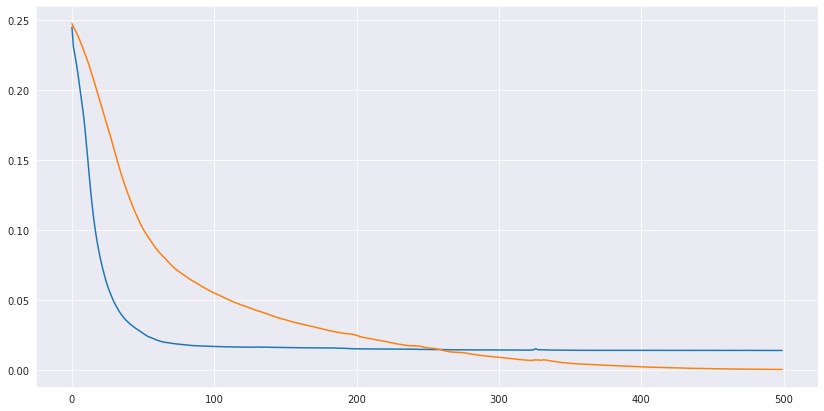

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history_02.history['loss'])
plt.plot(history_02.history['val_loss'])
plt.show()

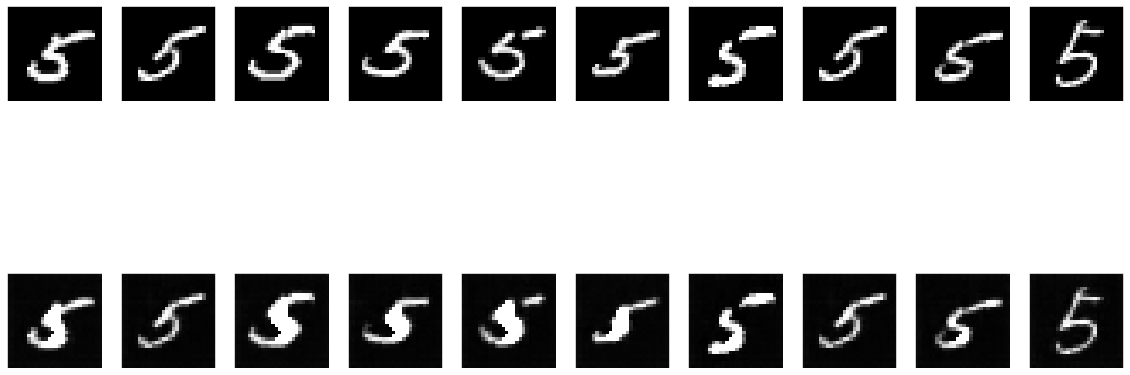

In [ ]:
plotImages(xTrain_10, predTest_01, shape=(28, 28))

#3-я своя архитектура

In [ ]:
def myAutocoderThree(shape = (28, 28, 1)):
  img_input = Input((shape))
  x = Conv2D(16, (3, 3), strides=2, padding='same', activation='relu')(img_input)
  x = Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(x)
  x = Dropout(0.1)(x)
  x = BatchNormalization()(x)
  x = Flatten()(x)

  z = Dense(8, activation='relu')(x)
  x = Dense(14*14*32, activation='relu')(z)
  x = Reshape((14, 14, 32))(x)
  x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
  model = Model(img_input, x)
  model.compile(loss='mean_squared_error', optimizer='adam')

  return model


In [ ]:
model_03 = myAutocoderThree()
model_03.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_44 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 32)          0         
                                                                 
 batch_normalization_32 (Bat  (None, 7, 7, 32)         128       
 chNormalization)                                                
                                                                 
 flatten_9 (Flatten)         (None, 1568)              0         
                                                           

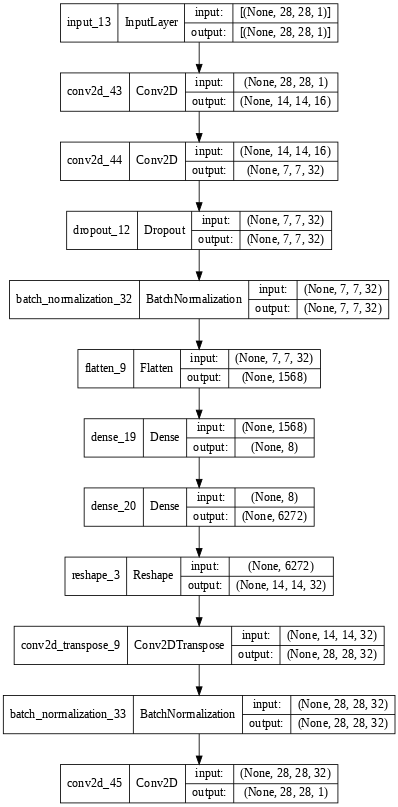

In [ ]:
utils.plot_model(model_03, dpi=60, show_shapes=True)

In [ ]:
history_03 = model_03.fit(xTrain_10, xTrain_10, batch_size=256, epochs=500, validation_data=(allFive, allFive))

Epoch 1/500
1/1 [==============================] - 1s 829ms/step - loss: 0.2376 - val_loss: 0.2477
Epoch 2/500
1/1 [==============================] - 0s 108ms/step - loss: 0.2300 - val_loss: 0.2458
Epoch 3/500
1/1 [==============================] - 0s 102ms/step - loss: 0.2272 - val_loss: 0.2436
Epoch 4/500
1/1 [==============================] - 0s 163ms/step - loss: 0.2229 - val_loss: 0.2412
Epoch 5/500
1/1 [==============================] - 0s 103ms/step - loss: 0.2168 - val_loss: 0.2386
Epoch 6/500
1/1 [==============================] - 0s 99ms/step - loss: 0.2083 - val_loss: 0.2359
Epoch 7/500
1/1 [==============================] - 0s 99ms/step - loss: 0.1993 - val_loss: 0.2331
Epoch 8/500
1/1 [==============================] - 0s 101ms/step - loss: 0.1878 - val_loss: 0.2303
Epoch 9/500
1/1 [==============================] - 0s 101ms/step - loss: 0.1747 - val_loss: 0.2275
Epoch 10/500
1/1 [==============================] - 0s 102ms/step - loss: 0.1627 - val_loss: 0.2247
Epoch 11/50

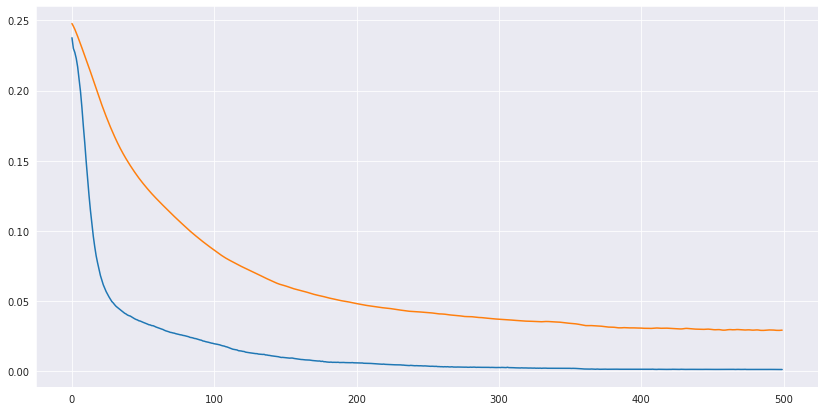

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(history_03.history['loss'])
plt.plot(history_03.history['val_loss'])
plt.show()

In [ ]:
predTest_03 = model_03.predict(xTrain_10)
predTest_03 = predTest_01*255
predTest_03 = predTest_01.astype('uint8')

In [ ]:
err_03 = [getMSE(xTrain_10[i], predTest_03[i]/255) for i in range(len(predTest_03))]

In [ ]:
print('ERROR:', sum(err_03)/predTest_03.shape[0])

ERROR: 0.017105265688605976


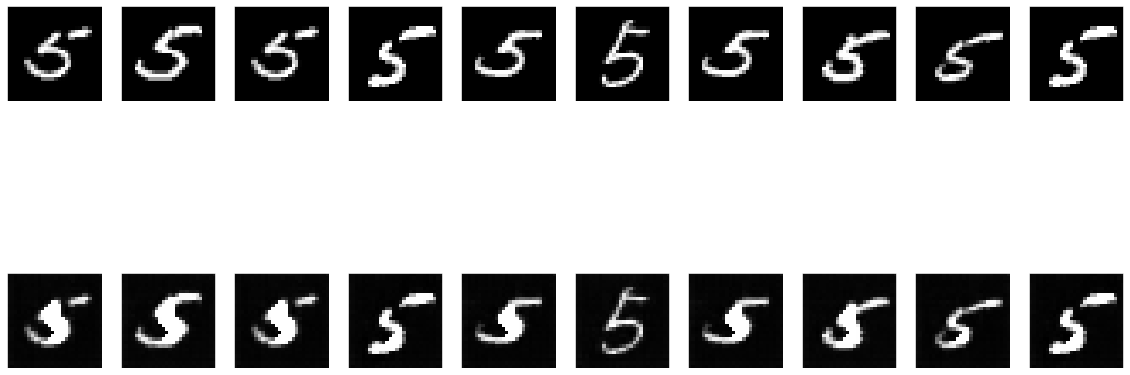

In [ ]:
plotImages(xTrain_10, predTest_03, shape=(28, 28))

# Одежда

In [ ]:
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()

In [ ]:
#xTrainMnistF = xTrainMnistF.astype('float32')/255 
#xTrainMnistF = xTrainMnistF.reshape(-1, 28, 28, 1) 
#xTestMnistF = xTestMnistF.astype('float32')/255 
#xTestMnistF = xTestMnistF.reshape(-1, 28, 28, 1) 

In [ ]:
n = 89
dr = xTrainMnistF[n].reshape((28, 28))
print(yTrainMnist[n])
dr.shape

4


(28, 28)

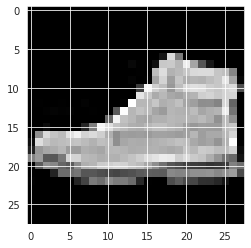

In [ ]:
img = Image.fromarray(dr)
plt.imshow(img.convert('RGBA'))
plt.show()

In [ ]:
xTrainF = xTrainMnistF[yTrainMnist!=4]
xTrainF = xTrainF.astype('float')/255
xTrainF = xTrainF.reshape(-1, 28, 28, 1)
xTrainF.shape

(54158, 28, 28, 1)

In [ ]:
model_fashion = myAutocoderTwo()
model_fashion.fit(xTrainF[20000:30000], xTrainF[20000:30000], epochs= 100, batch_size=256, validation_data = (xTrainF[30000:31000], xTrainF[30000:31000]))

Epoch 1/100
40/40 [==============================] - 1s 19ms/step - loss: 0.0534 - val_loss: 0.1402
Epoch 2/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0215 - val_loss: 0.1293
Epoch 3/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0151 - val_loss: 0.1201
Epoch 4/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0118 - val_loss: 0.1146
Epoch 5/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0096 - val_loss: 0.1115
Epoch 6/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0080 - val_loss: 0.1006
Epoch 7/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0070 - val_loss: 0.0874
Epoch 8/100
40/40 [==============================] - 1s 14ms/step - loss: 0.0062 - val_loss: 0.0775
Epoch 9/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0059 - val_loss: 0.0514
Epoch 10/100
40/40 [==============================] - 1s 16ms/step - loss: 0.0055 - val_loss: 0.0269

In [ ]:
x_train_4 = xTrainMnistF[yTrainMnistF == 4]
x_train_4 = x_train_4/255
predMnistF = model_fashion.predict(x_train_4[:50])

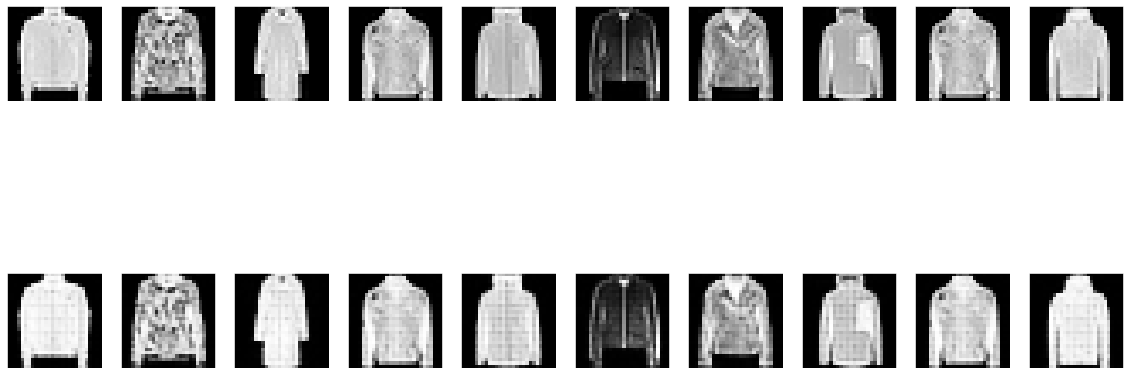

In [ ]:
plotImages(x_train_4, predMnistF, shape=(28, 28))